In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from keras import layers
from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from textblob import TextBlob
from textblob import Word

import re
import string

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_file = "drive/My Drive/Final year project/train.csv"
test_data_file = "drive/My Drive/Final year project/test.csv"
submission_file = "drive/My Drive/Final year project/test.csv"

train_data = pd.read_csv(train_data_file)
test_data = pd.read_csv(test_data_file)
submission_result = pd.read_csv(test_data_file)

# Preprocessing

In [ ]:
# set up paramters
max_len = 120
embedding_dim = 300
vocabulary_size = 20000
num_tokens = vocabulary_size+1 #including 0

In [ ]:
# preprocess comment texts
def preprocess(corpus):

# remove all non-English characters
# and convert all letters to lower case
    printable = set(string.printable)
    corpus = ''.join(filter(lambda x: x in printable, corpus))
    corpus = corpus.lower()

# change contracted words into possible non-contracted form
    # specific
    corpus = re.sub(r"won't", "will not", corpus)
    corpus = re.sub(r"can\'t", "can not", corpus)
    # or could be 'are not' etc
    corpus = re.sub(r"ain\'t","is not", corpus)
    corpus = re.sub(r"shan\'t", "shall not", corpus)
    corputs = re.sub(r"let\'s", "let us", corpus)

    # general
    corpus = re.sub(r"n\'t", " not", corpus)
    corpus = re.sub(r"\'re", " are", corpus)
    corpus = re.sub(r"\'s", " is", corpus)
    # or could be \'d --> had
    corpus = re.sub(r"\'d", " would", corpus)
    corpus = re.sub(r"\'ll", " will", corpus)
    corpus = re.sub(r"\'t", " not", corpus)
    corpus = re.sub(r"\'ve", " have", corpus)
    corpus = re.sub(r"\'m", " am", corpus)

    # replace the rest \' with ' '
    corpus = re.sub(r"\'", " ", corpus)

    correction_list = {"youfuck": "you fuck", \
                       "fucksex": "fuck sex",\
                       "bitchbot": "bitch bot",\
                       "offfuck": "fuck off",\
                       "donkeysex": "donkey sex",\
                      "securityfuck": "security fuck",\
                      "ancestryfuck": "ancestry fuck",\
                      "turkeyfuck": "turkey fuck",\
                      "faggotgay": "faggot gay",\
                       "fuckbot": "fuck bot",\
                       "assfuckers": "ass fucker",\
                       "ckckck": "cock",\
                       "fuckfuck": "fuck",\
                       "lolol": "lol",\
                       "pussyfuck": "fuck",\
                        "gaygay": "gay",\
                       "haha": "ha",\
                       "sucksuck": "suck"
                      }
    for old,new in correction_list.items():
        corpus = corpus.replace(old,new)

    return corpus

In [ ]:
# tokenizer vocabulary_size words
# we ignore all numbers
tokenizer = Tokenizer(num_words = vocabulary_size+1,\
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789',\
                      lower=True, split=' ')

# extract comment texts from train_data and test_data
X_train_raw = train_data["comment_text"]
X_test_raw = test_data["comment_text"]

bad_comment_cat = ['toxic', 'severe_toxic', 'obscene', 'threat',\
       'insult', 'identity_hate']
Y_train = train_data[bad_comment_cat]

In [ ]:
# preprocess data
X_train_raw = X_train_raw.apply(lambda x: preprocess(str(x)))
X_test_raw = X_test_raw.apply(lambda x: preprocess(str(x)))
# example X_train_raw.loc[126]

# tokenize comment text
tokenizer.fit_on_texts(X_train_raw)
tokenizer.fit_on_texts(X_test_raw)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_raw),\
                        maxlen = max_len, truncating = "pre")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_raw),\
                       maxlen = max_len, truncating = "pre")

# shuffle training data and split it into a training part and a validation part
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,train_size=0.9, random_state=199)
print(x_train.shape," ",y_train.shape," ",x_val.shape," ",y_val.shape)

(143613, 120)   (143613, 6)   (15958, 120)   (15958, 6)


# RNN models

In [ ]:
def get_weights(embedding_vectors,embedding_dim):
    global num_tokens,tokenizer

    # assign vectors to words using the pretrained model embedding_vectors
    embedding_weights = np.zeros((num_tokens,embedding_dim))

    # count how many words are not assigned with the pretrained model.
    # By default, vectors associated to words are zero vectors.
    misses = 0

    # the index in word_index starts with 1
    for word, i in tokenizer.word_index.items():
        vector = embedding_vectors.get(word)
        # the word_index is ordered by word frequency
        if i>=num_tokens :
            break
        elif vector is not None:
            embedding_weights[i] = vector
        else:
            if len(word)<20:
                word = Word(word)
                word = word.spellcheck()[0][0]
                vector = embedding_vectors.get(str(word))
                if vector is not None:
                    embedding_weights[i] = vector
                else:
                    misses +=1
                    #print(word)
            else:
                misses +=1
                #print(word)

    print(f"The number of missed words is {misses}")

    return embedding_weights

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2023-04-12 10:40:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.91, 18.165.83.44, 18.165.83.35, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G   252MB/s    in 6.9s    

2023-04-12 10:40:47 (209 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [ ]:
!unzip crawl*.zip
!ls
!pwd

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       
crawl-300d-2M.vec  crawl-300d-2M.vec.zip  drive  sample_data
/content


In [ ]:
# read the pretrained model fastText
embedding_vectors_fasttext = {}
with open("crawl-300d-2M.vec","r") as file:
    file.readline()
    for line in file:
        word , vector = line.split(maxsplit=1)
        vector = np.fromstring(vector,"float32",sep=" ")
        embedding_vectors_fasttext[word] = vector

In [ ]:
# assign vectors to words using the pretrained model fasttext
embedding_weights_fasttext = get_weights(embedding_vectors_fasttext,embedding_dim=300)

The number of missed words is 380


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-04-12 10:45:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-12 10:45:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-12 10:45:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip
!ls
!pwd

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
crawl-300d-2M.vec      glove.6B.100d.txt  glove.6B.50d.txt
crawl-300d-2M.vec.zip  glove.6B.200d.txt  glove.6B.zip
drive		       glove.6B.300d.txt  sample_data
/content


In [ ]:
# read the pretrained model GloVe
embedding_vectors_glove = {}
with open("glove.6B.300d.txt","r") as file:
    for line in file:
        word , vector = line.split(maxsplit=1)
        vector = np.fromstring(vector,"float32",sep=" ")
        embedding_vectors_glove[word] = vector

In [ ]:
# assign vectors to words using the pretrained model GloVe
embedding_weights_glove = get_weights(embedding_vectors_glove,embedding_dim=300)

The number of missed words is 481


In [ ]:
def GRU_model_glove():
    global max_len,num_tokens,embedding_weights_glove

    inputs = layers.Input(shape=(max_len,))

    x = layers.Embedding(input_dim=num_tokens,\
                         output_dim=embedding_dim,\
                         embeddings_initializer=keras.initializers.Constant(embedding_weights_glove),\
                         trainable=True)(inputs)

    x = layers.SpatialDropout1D(0.3)(x)

    forward_layer = layers.GRU(42,return_sequences=True)
    backward_layer = layers.GRU(42,activation="relu",dropout=0.1,return_sequences=True,go_backwards=True)
    x = layers.Bidirectional(forward_layer,backward_layer=backward_layer)(x)

    x = layers.GlobalMaxPooling1D()(x)

    outputs = layers.Dense(units=6,activation='sigmoid')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs, name="GRU_model_glove")

    model.compile(optimizer=tf.optimizers.Adam(),\
                  loss=tf.losses.BinaryCrossentropy(),\
                  metrics=['AUC'])

    return model

GRU_model_glove = GRU_model_glove()
GRU_model_glove.summary()

Model: "GRU_model_glove"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 embedding (Embedding)       (None, 120, 300)          6000300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 120, 84)          86688     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 84)               0         
 lMaxPooling1D)                                                  
                                                   

In [ ]:
history = GRU_model_glove.fit(x_train, y_train, epochs=2,\
                              batch_size=32, validation_data=(x_val,y_val))

Epoch 1/2
4488/4488 [==============================] - 1638s 363ms/step - loss: 0.0547 - auc: 0.9769 - val_loss: 0.0435 - val_auc: 0.9859
Epoch 2/2
4488/4488 [==============================] - 1540s 343ms/step - loss: 0.0415 - auc: 0.9873 - val_loss: 0.0433 - val_auc: 0.9842


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
prediction = GRU_model_glove.predict(x_val)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_val, y_pred))
print('F1-score: ', f1_score(y_val, y_pred,average='micro'))
print("Precision Score : ",precision_score(y_val, y_pred,  average='micro'))
print("Recall Score : ",recall_score(y_val, y_pred, average='micro'))

499/499 [==============================] - 14s 28ms/step
Accuracy of the model :  0.9233613234741196
F1-score:  0.7476814838503357
Precision Score :  0.8422190201729106
Recall Score :  0.672225416906268


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Toxic', 'severe_toxic', 'obscene','threat','insult','identity hate']
print(classification_report(y_val, y_pred, target_names=target_names))

               precision    recall  f1-score   support

        Toxic       0.85      0.74      0.79      1554
 severe_toxic       0.61      0.25      0.36       146
      obscene       0.90      0.74      0.81       824
       threat       0.59      0.34      0.43        47
       insult       0.85      0.61      0.71       768
identity hate       0.55      0.43      0.48       139

    micro avg       0.84      0.67      0.75      3478
    macro avg       0.72      0.52      0.60      3478
 weighted avg       0.84      0.67      0.74      3478
  samples avg       0.07      0.06      0.06      3478



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_val1=y_val.to_numpy()

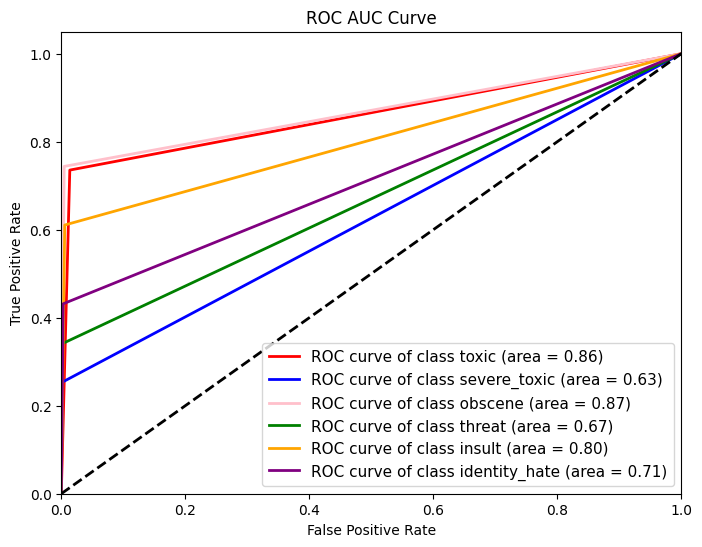

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assuming y_pred is the predicted probabilities for each class
# and y_true is the true labels for each class
n_classes = y_pred.shape[1]

# calculate the fpr and tpr for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

j=-1
# plot the ROC AUC curve for each class
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'pink', 'green', 'orange', 'purple']  # add more colors if needed
for i, color in zip(range(n_classes), colors):
    j+=1
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(bad_comment_cat[j], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # add diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right",fontsize=11)
plt.show()

In [ ]:
def GRU_model_fasttext():
    global max_len,num_tokens,embedding_weights_fasttext

    inputs = layers.Input(shape=(max_len,))

    x = layers.Embedding(input_dim=num_tokens,\
                         output_dim=embedding_dim,\
                         embeddings_initializer=keras.initializers.Constant(embedding_weights_fasttext),\
                         trainable=False)(inputs)

    x = layers.SpatialDropout1D(0.3)(x)

    forward_layer = layers.GRU(64,return_sequences=True)
    backward_layer = layers.GRU(64,activation="relu",dropout=0.3,return_sequences=True,go_backwards=True)
    x = layers.Bidirectional(forward_layer,backward_layer=backward_layer)(x)

    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool,max_pool])

    outputs = layers.Dense(units=6,activation='sigmoid')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs, name="GRU_model")

    model.compile(optimizer=tf.optimizers.Adam(),\
                  loss=tf.losses.BinaryCrossentropy(),\
                  metrics=['AUC'])

    return model

GRU_model_fasttext = GRU_model_fasttext()
GRU_model_fasttext.summary()


Model: "GRU_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 120, 300)     6000300     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 120, 300)    0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 120, 128)    140544      ['spatial_dropout1d_1[0][

In [ ]:
history1 = GRU_model_fasttext.fit(x_train, y_train, \
                                 epochs=2, batch_size=32,\
                                 validation_data=(x_val,y_val))

Epoch 1/2
4488/4488 [==============================] - 1407s 312ms/step - loss: 0.0550 - auc: 0.9774 - val_loss: 0.0461 - val_auc: 0.9867
Epoch 2/2
4488/4488 [==============================] - 1396s 311ms/step - loss: 0.0444 - auc: 0.9856 - val_loss: 0.0426 - val_auc: 0.9868


In [ ]:
prediction2 = GRU_model_fasttext.predict(x_val)
y_pred = (prediction2 > 0.5)
print("Accuracy of the model : ", accuracy_score(y_val, y_pred))
print('F1-score: ', f1_score(y_val, y_pred,average='micro'))
print("Precision Score : ",precision_score(y_val, y_pred,  average='micro'))
print("Recall Score : ",recall_score(y_val, y_pred, average='micro'))

499/499 [==============================] - 13s 25ms/step
Accuracy of the model :  0.9224213560596566
F1-score:  0.7739319333816076
Precision Score :  0.7796906915669682
Recall Score :  0.7682576193214491


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Toxic', 'severe_toxic', 'obscene','threat','insult','identity hate']
print(classification_report(y_val, y_pred, target_names=target_names))

               precision    recall  f1-score   support

        Toxic       0.83      0.79      0.81      1554
 severe_toxic       0.48      0.45      0.46       146
      obscene       0.84      0.84      0.84       824
       threat       0.58      0.38      0.46        47
       insult       0.72      0.79      0.75       768
identity hate       0.56      0.48      0.52       139

    micro avg       0.78      0.77      0.77      3478
    macro avg       0.67      0.62      0.64      3478
 weighted avg       0.78      0.77      0.77      3478
  samples avg       0.07      0.07      0.07      3478



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_val2=y_val.to_numpy()

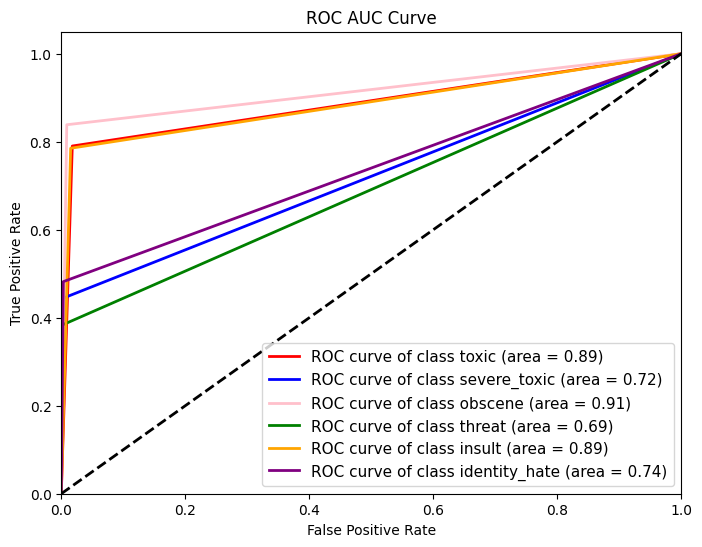

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assuming y_pred is the predicted probabilities for each class
# and y_true is the true labels for each class
n_classes = y_pred.shape[1]

# calculate the fpr and tpr for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val2[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

j=-1
# plot the ROC AUC curve for each class
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'pink', 'green', 'orange', 'purple']  # add more colors if needed
for i, color in zip(range(n_classes), colors):
    j+=1
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(bad_comment_cat[j], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # add diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right",fontsize=11)
plt.show()

# Ensemble

In [ ]:
model_nums = 2
size1 = x_train.shape[0]

y_train_pred = np.zeros((model_nums,size1,6),dtype="float32")
y_train_pred[0] = GRU_model_fasttext.predict(x_train)
y_train_pred[1] = GRU_model_glove.predict(x_train)

size2 = x_val.shape[0]
y_test_pred = np.zeros((model_nums,size2,6),dtype="float32")
y_test_pred[0] = GRU_model_fasttext.predict(x_val)
y_test_pred[1] = GRU_model_glove.predict(x_val)

y_pred_en = np.zeros((size2,6),dtype="float32")

for i in range(6):
    lg = LogisticRegression()
    temp = np.zeros((size1,model_nums),dtype="float32")
    for j in range(model_nums):
        temp[:,j] = y_train_pred[j,:,i]
    lg.fit(temp,y_train[bad_comment_cat[i]])

    temp = np.zeros((size2,model_nums),dtype="float32")
    for j in range(model_nums):
        temp[:,j] = y_test_pred[j,:,i]
    y_pred_en[:,i] = lg.predict_proba(temp)[:,1]

499/499 [==============================] - 13s 27ms/step


In [ ]:
y_pred_en_prob=y_pred_en.copy()

In [ ]:
from sklearn.metrics import classification_report

y_pred_en_tf=(y_pred_en > 0.5)
print("Accuracy of the model : ", accuracy_score(y_val, y_pred_en_tf))
print('F1-score: ', f1_score(y_val, y_pred_en_tf,average='micro'))
print("Precision Score : ",precision_score(y_val, y_pred_en_tf,  average='micro'))
print("Recall Score : ",recall_score(y_val, y_pred_en_tf, average='micro'))

Accuracy of the model :  0.9241132974056899
F1-score:  0.7575331772053083
Precision Score :  0.8288349846258968
Recall Score :  0.6975273145485912


In [ ]:
y_val3=y_val.to_numpy()

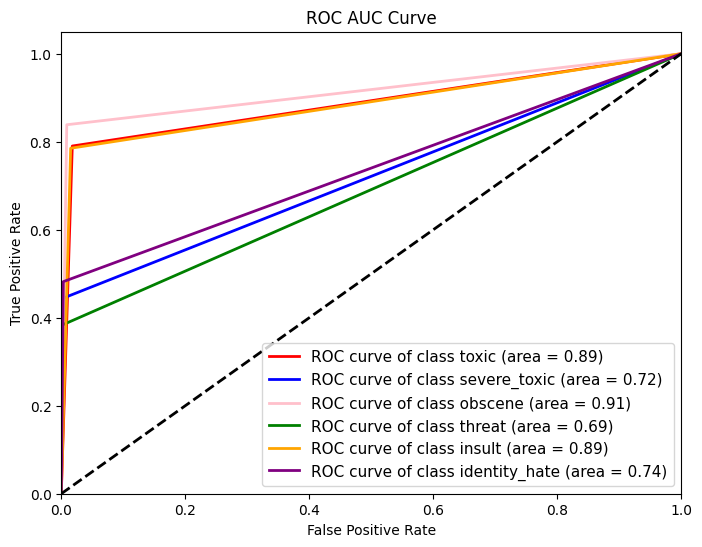

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assuming y_pred is the predicted probabilities for each class
# and y_true is the true labels for each class
n_classes = y_pred.shape[1]

# calculate the fpr and tpr for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val3[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

j=-1
# plot the ROC AUC curve for each class
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'pink', 'green', 'orange', 'purple']  # add more colors if needed
for i, color in zip(range(n_classes), colors):
    j+=1
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(bad_comment_cat[j], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # add diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right",fontsize=11)
plt.show()


# Submission

In [ ]:
model_nums = 2
size1 = x_train.shape[0]
y_pred_1=y_pred.copy()
y_train_pred = np.zeros((model_nums,size1,6),dtype="float32")
y_train_pred[0] = GRU_model_fasttext.predict(x_train)
y_train_pred[1] = GRU_model_glove.predict(x_train)

size2 = X_test.shape[0]
y_test_pred = np.zeros((model_nums,size2,6),dtype="float32")
y_test_pred[0] = GRU_model_fasttext.predict(X_test)
y_test_pred[1] = GRU_model_glove.predict(X_test)

y_pred_1 = np.zeros((size2,6),dtype="float32")

for i in range(6):
    lg = LogisticRegression()
    temp = np.zeros((size1,model_nums),dtype="float32")
    for j in range(model_nums):
        temp[:,j] = y_train_pred[j,:,i]
    lg.fit(temp,y_train[bad_comment_cat[i]])

    temp = np.zeros((size2,model_nums),dtype="float32")
    for j in range(model_nums):
        temp[:,j] = y_test_pred[j,:,i]
    y_pred_1[:,i] = lg.predict_proba(temp)[:,1]

4787/4787 [==============================] - 131s 27ms/step


In [ ]:
submission_result[bad_comment_cat] = y_pred_1
submission_result.to_csv("submission.csv",index=False)

In [ ]:
submission = pd.read_csv('submission.csv')

In [ ]:
submission.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.988790,0.647468,0.988266,0.004455,0.925362,0.021831
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.009345,0.002626,0.005301,0.001126,0.006417,0.002393
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.010713,0.002657,0.005501,0.001132,0.006621,0.002404
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.009333,0.002626,0.005291,0.001127,0.006413,0.002392
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.009726,0.002635,0.005320,0.001130,0.006460,0.002395
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0.009405,0.002627,0.005295,0.001128,0.006446,0.002394
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,0.009496,0.002628,0.005316,0.001127,0.006474,0.002392
7,000247e83dcc1211,:Dear god this site is horrible.,0.908571,0.002852,0.007964,0.001166,0.019555,0.002493
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",0.015869,0.002646,0.005848,0.001130,0.009627,0.002404
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,0.009229,0.002625,0.005280,0.001126,0.006396,0.002392


In [ ]:
# Get user comment as input
comment = input("Enter your comment: ")


Enter your comment: you aaare suxh an assssholeeeeeee!!!!!!!


In [ ]:
test_seq = pad_sequences(tokenizer.texts_to_sequences([comment]), maxlen=max_len)
y_pred = GRU_model_glove.predict(test_seq)
print(comment)
print(bad_comment_cat)
print(y_pred)

1/1 [==============================] - 0s 64ms/step
you aaare suxh an assssholeeeeeee!!!!!!!
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[[0.23836485 0.00525898 0.02619793 0.00113658 0.06002143 0.00143023]]
